# Operator Inference with Optimization for Energy-Preserving Burger's Equation

Here we implment the operator inference solved with a non-constrained optimization approach rather than a linear least square approach shown in notebook 02. This is the reproduction of the results from [Peherstorfer and Willcox](https://www.sciencedirect.com/science/article/pii/S0045782516301104?via%3Dihub). With the Burgers' equation developed in the paper by [H. Aref and P. K. Daripa](https://epubs.siam.org/doi/10.1137/0905060).

## Packages

In [1]:
using DataFrames
using FileIO
using JLD2
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

## Initial Setup

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

Main.LiftAndLearn

## Non-Constrained Optimization

In [3]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10, "periodic"
);
burger.IC = sin.(2 * pi * burger.x)

# ic_a = range(0.8, 1.2, 10);  # coefficient that changes the initial condition for training data
ic_a = 1.0

1.0

### Multiple $\mu$ test

In [4]:
num_ICs = length(ic_a)
rmax = 15

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    has_control=false,
    has_output=false,
    optimization="NC",  #!!! This options changes the problem into an optimization problem
    opt_verbose=false,
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    initial_guess_for_opt=false,
    which_quad_term="F"
)
Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
k = 0
proj_err = zeros(rmax - k, burger.Pdim)
intru_state_err = zeros(rmax - k, burger.Pdim)
opinf_state_err = zeros(rmax - k, burger.Pdim)

# Downsampling rate
DS = 5

@info "Compute inferred and intrusive operators and calculate the errors"
for i in 1:length(burger.μs)
    μ = burger.μs[i]

    ## Create testing data
    A, F = burger.generateEPmatrix(burger, μ)
    Xtest = burger.semiImplicitEuler(A, F, burger.t, burger.IC)

    op_burger = LnL.operators(A=A, F=F)

    ## training data for inferred dynamical models
    Xall = Vector{Matrix{Float64}}(undef, num_ICs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
    for j in 1:num_ICs
        states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] * burger.IC)
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    X = reduce(hcat, Xall)
    R = reduce(hcat, Xdotall)
    
    U = zeros(1,1)  # when no inputs define input as a 0 matrix
    Y = zeros(1,1)  # when no outputs define the output as a 0 matrix
    
    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]

    # Compute the values for the intrusive model from the basis of the training data
    op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

    # Compute the inferred operators from the training data
    if options.reproject
        op_inf = LnL.inferOp(X, U, Y, Vrmax, op_burger, options, op_int)  # Using Reprojection and Initial Guess
    else
        op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options, op_int)  # without reprojection but with initial guess
    end

    for j = 1+k:rmax
        Vr = Vrmax[:, 1:j]  # basis
        
        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, j)
        Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC)  # use F
        
        # Integrate the inferred model
        Finf_extract = LnL.extractF(op_inf.F, j)
        Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], Finf_extract, burger.t, Vr' * burger.IC)  # use F
        
        # error values
        proj_err[j-k, i] = LnL.compProjError(Xtest, Vr)
        intru_state_err[j-k, i] = LnL.compStateError(Xtest, Xint, Vr)
        opinf_state_err[j-k, i] = LnL.compStateError(Xtest, Xinf, Vr)
    end
end

## Results

In [5]:
proj_err_mean = nanmean(proj_err, dims=2)
intru_state_err_mean = nanmean(intru_state_err, dims=2)
opinf_state_err_mean = nanmean(opinf_state_err, dims=2)

df = DataFrame(
    order=1+k:rmax,
    projection_err=vec(proj_err_mean),
    intrusive_state_err=vec(intru_state_err_mean),
    inferred_state_err=vec(opinf_state_err_mean),
)

Row,order,projection_err,intrusive_state_err,inferred_state_err
,Int64,Float64,Float64,Float64
1,1,0.0116631,0.0117418,0.0117421
2,2,0.00203753,0.00299086,0.00300113
3,3,0.000924848,0.00131608,0.00132432
4,4,0.000425646,0.000573186,0.000579906
5,5,0.000276936,0.000347846,0.000351257
6,6,0.000217384,0.000260125,0.00317958
7,7,0.000160802,0.000186265,0.014101
8,8,9.83969e-5,0.000118111,0.0265176
9,9,6.69041e-5,8.04371e-5,0.0312703


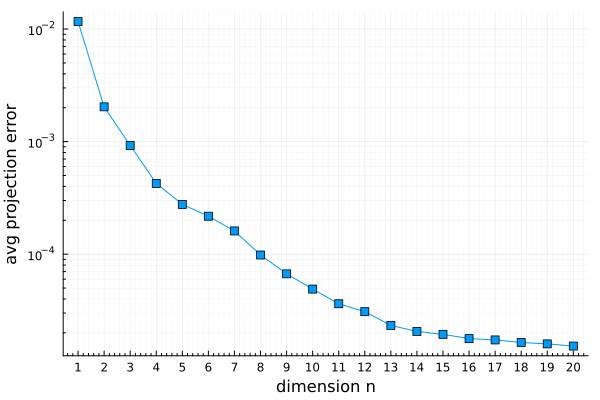

In [6]:
# Projection error
plot(df.order, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(df.projection_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg projection error")

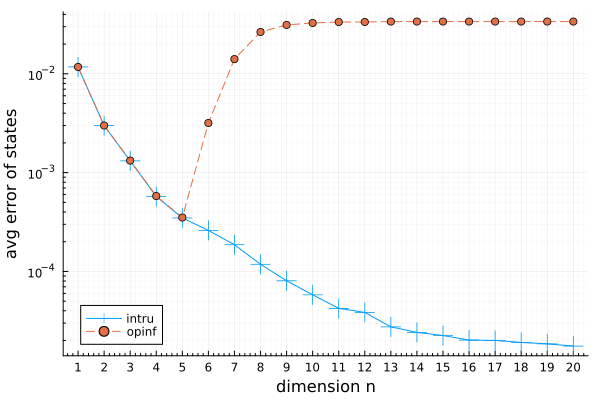

In [7]:
# State errors
plot(df.order, df.intrusive_state_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)

yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of states")

Due to downsampling we have a different trend from the least square solution

### Single $\mu$ test and less initial conditions

In [4]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10
)
burger.IC = sin.(2 * pi * burger.x)
ic_a = 1.0
num_ICs = length(ic_a)
rmax = 15

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    has_control=false,
    has_output=false,
    optimization="NCT",  #!!! This options changes the problem into an optimization problem
    opt_verbose=true,
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    initial_guess_for_opt=false,
    which_quad_term="F",
    λ_lin = 0.02,
    λ_quad = 0.01
)
# make it smaller but bigger than 0.01
Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
k = 0
proj_err = zeros(rmax - k, 1)
intru_state_err = zeros(rmax - k, 1)
opinf_state_err = zeros(rmax - k, 1)

# Downsampling rate
DS = 5
;

In [5]:
@info "Generate testing data"
μ = 0.3

## Create testing data
A, F = burger.generateEPmatrix(burger, μ)
Xtest = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
op_burger = LnL.operators(A=A, F=F)
;

┌ Info: Generate testing data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [6]:
@info "Generate training data for inferred dynamical models"
## training data for inferred dynamical models
Xall = Vector{Matrix{Float64}}(undef, num_ICs)
Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
for j in 1:num_ICs
    states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] * burger.IC)
    tmp = states[:, 2:end]
    Xall[j] = tmp[:, 1:DS:end]  # downsample data
    tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
    Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)
U = zeros(1,1)  # when no inputs define input as a 0 matrix
Y = zeros(1,1)  # when no outputs define the output as a 0 matrix

# compute the POD basis from the training data
tmp = svd(X)
Vrmax = tmp.U[:, 1:rmax]
;

┌ Info: Generate training data for inferred dynamical models
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [7]:
@info "Compute the intrusive model"
# Compute the values for the intrusive model from the basis of the training data
op_int = LnL.intrusiveMR(op_burger, Vrmax, options)
;

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [8]:
@info "Compute the inferred model"

@load "data/ep-burgers_LS_op.jld2" op_inf_LS

# Compute the inferred operators from the training data
if options.reproject
    op_inf = LnL.inferOp(X, zeros(1,1), zeros(1,1), Vrmax, op_burger, options, op_inf_LS)  # Using Reprojection and Initial Guess
else
    op_inf = LnL.inferOp(X, zeros(1,1), zeros(1,1), Vrmax, Vrmax' * R, options, op_inf_LS)  # without reprojection 
end
;

┌ Info: Compute the inferred model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:25
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:61
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:63



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   137700

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

┌ Info: constraint         = Non-Constrained
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:65
┌ Info: order              = 15
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:66
┌ Info: termination_status = LOCALLY_SOLVED
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:67
┌ Info: primal_status      = FEASIBLE_POINT
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:68
┌ Info: objective_value    = 6477.336512580605
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:69


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:82


In [9]:
@info "Compute the errors"
for j = 1+k:rmax
    Vr = Vrmax[:, 1:j]  # basis
    
    # Integrate the intrusive model
    Fint_extract = LnL.extractF(op_int.F, j)
    Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC)  # use F
    
    # Integrate the inferred model
    Finf_extract = LnL.extractF(op_inf.F, j)
    Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], Finf_extract, burger.t, Vr' * burger.IC)  # use F
    
    # error values
    proj_err[j-k] = LnL.compProjError(Xtest, Vr)
    intru_state_err[j-k] = LnL.compStateError(Xtest, Xint, Vr)
    opinf_state_err[j-k] = LnL.compStateError(Xtest, Xinf, Vr)
end

┌ Info: Compute the errors
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


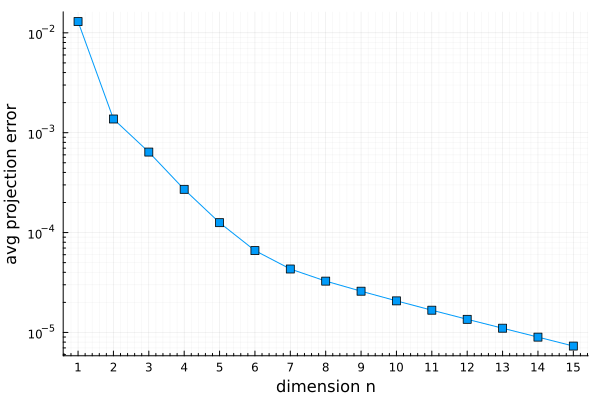

In [11]:
# Projection error
plot(1+k:rmax, proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(1+k:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")

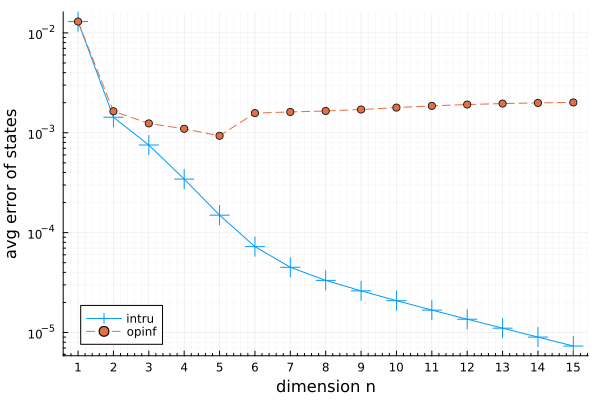

In [12]:
# State errors
plot(1+k:rmax, intru_state_err, marker=(:cross, 10), label="intru")
plot!(1+k:rmax, opinf_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(1+k:rmax)
xlabel!("dimension n")
ylabel!("avg error of states")

In [ ]:
op_nc_opinf = op_inf
@save "data/ep-burgers_ncopinf_op.jld2" op_nc_opinf